In [1]:
%matplotlib notebook

In [2]:
from importlib import reload
from two_transmons import Rabi
reload(Rabi)
from scipy.optimize import *
from two_transmons.Rabi import *
import two_transmons.DoubleTransmonSystem
from two_transmons.DoubleTransmonSystem import *
import two_transmons.VacuumRabiSimulation
from two_transmons.VacuumRabiSimulation import *
import single_transmon.Transmon
from single_transmon.Transmon import *
from ReadoutResonator import *
from qutip import *
from tqdm.notebook import tqdm
from two_transmons.ZPulse import *
from importlib import reload
import two_transmons.ParallelCalculations
from two_transmons.ParallelCalculations import *
from two_transmons.CalcTime import *
from two_transmons.Tomography import *
from scipy.linalg import cholesky
from p_tqdm import p_map, p_imap
import time
from qiskit.pulse import *

In [3]:
len(Drag (130, 0.5, 20, 0.1, name = 'Hdr1').get_waveform().samples)

130

# Single transmon dynamic

In [4]:
Nc = 7
Ec1 = 0.25 * 2 * np.pi

Ej1 = Ec1 * 100

d = 0.2

T1_1, T2_1 = 10e6, 5e6


tr1 = Transmon(Ec1, Ej1, d, 1/T1_1, 1/T2_1, Nc, 3, 1)
freq_lim = 0.2
farg=cook_farg(20,freq_lim)
params=farg[0]['params']
flux = params['phi_base_level']
Ts = linspace(0,params['finish'],params['t_points'])
rho0 = ket2dm(basis(3,0))

/tmp/ipykernel_1333898/3574378948.py:16: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  Ts = linspace(0,params['finish'],params['t_points'])


In [8]:
H0 = tr1.H_diag_trunc_approx(flux)

evals, evecs = tr1.H_diag_trunc_approx(flux).eigenstates()
freq = (evals[1]- evals[0])/2/pi

Hdr = tr1.Hdr_RF_RWA(0.01*2*pi/2*3/5, 100, 33.45*5,0)
Huu = tr1.H_uu(freq)*(-1)
H = [H0]+ [Hdr]+[Huu]
ops = [tr1.sx(),tr1.sy(), tr1.sz(), tr1.f_state()*tr1.f_state().dag()]

In [9]:
H[1]

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0.         1.         0.        ]
  [1.         0.         1.38518736]
  [0.         1.38518736 0.        ]],
 '0.5*0.018850*(1+np.sign(t-100.000000))*(1+np.sign(-t+267.250000))/4']

In [10]:
result = mesolve(H, rho0, Ts, c_ops = [],e_ops = ops,progress_bar=True,options=Options(nsteps = 20000, max_step = 1e-2, 
                                                                                       store_states = True))

10.0%. Run time:   0.06s. Est. time left: 00:00:00:00
20.0%. Run time:   0.12s. Est. time left: 00:00:00:00
30.0%. Run time:   0.19s. Est. time left: 00:00:00:00
40.0%. Run time:   0.25s. Est. time left: 00:00:00:00
50.0%. Run time:   0.31s. Est. time left: 00:00:00:00
60.0%. Run time:   0.37s. Est. time left: 00:00:00:00
70.0%. Run time:   0.43s. Est. time left: 00:00:00:00
80.0%. Run time:   0.49s. Est. time left: 00:00:00:00
90.0%. Run time:   0.56s. Est. time left: 00:00:00:00
Total run time:   0.62s


<IPython.core.display.Javascript object>


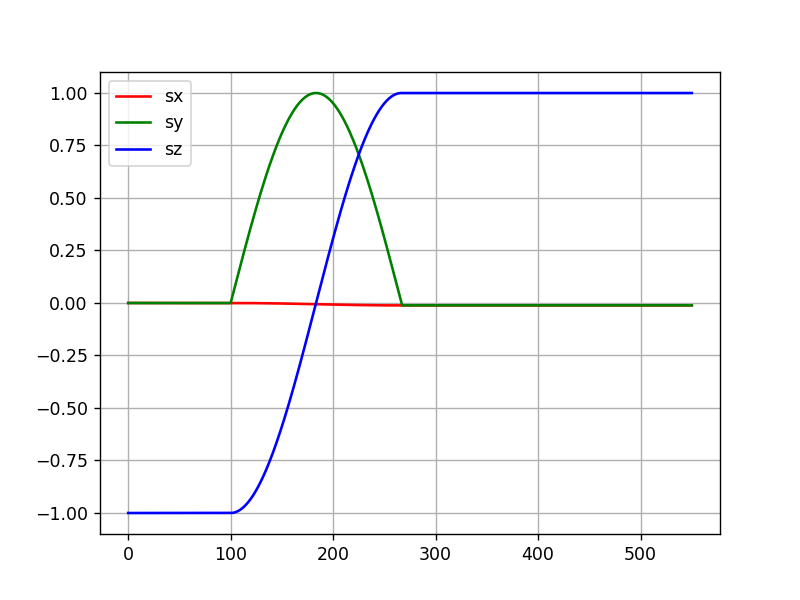

In [14]:
figure()
plot (Ts, result.expect[0],'r', label = 'sx')
plot (Ts, result.expect[1], 'g', label = 'sy')
plot (Ts, result.expect[2], 'b', label = 'sz')
legend()
grid()


<IPython.core.display.Javascript object>


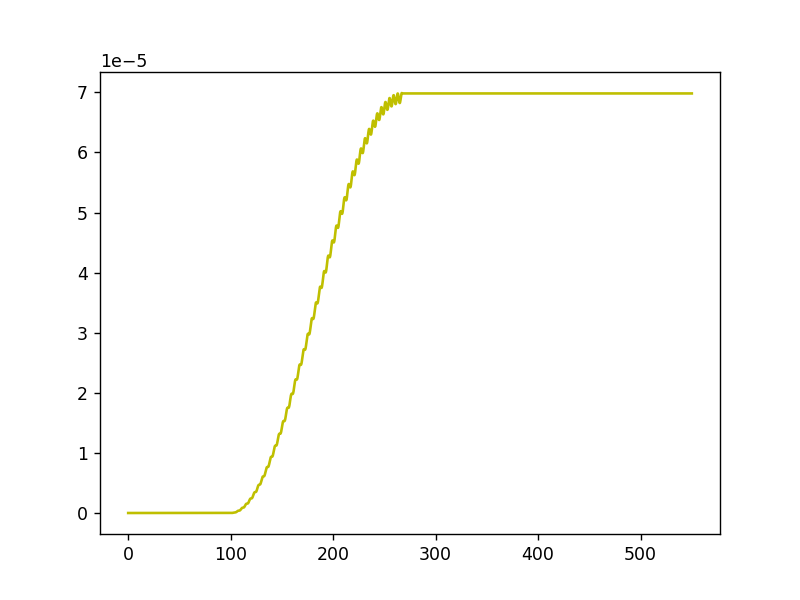

In [15]:
figure()
plot (Ts, result.expect[3], 'y', label = '2')

## Zgate

In [8]:
signal = ZPulse(Ts,params)
waveform = signal.waveform_iswap_zgate(1, t_start = 250, t_finish = 310, t_zgate = 20)

In [9]:
Htd = tr1.H_td_diag_trunc_approx(waveform)
evals, evecs = tr1.H_diag_trunc_approx(flux).eigenstates()
freq = (evals[1]- evals[0])/2/pi
#Hdr = tr1.Hdr(0.01*2*pi/2*3/5, 33.45*5/2, 10, 0, freq, params['phi_base_level'])
Hdr = tr1.Hdr_RF_RWA(0.01*2*pi/2*3/5, 10, 33.45*5/2,pi/2)
Huu = Huu = tr1.H_uu(freq)*(-1)
H = Htd + [Hdr] + [Huu]
ops = [tr1.sx(),tr1.sy(), tr1.sz()]


In [10]:
tr1.Hdr_RF_RWA(0.01*2*pi/2*3/5, 10, 33.45*5/2,0/2)

[Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
 Qobj data =
 [[0.         1.         0.        ]
  [1.         0.         1.38518736]
  [0.         1.38518736 0.        ]],
 '0.5*0.018850*(1+np.sign(t-10.000000))*(1+np.sign(93.625000-t))/4']

In [11]:
Huu

Quantum object: dims = [[3], [3]], shape = (3, 3), type = oper, isherm = True
Qobj data =
[[  0.           0.           0.        ]
 [  0.         -20.90463923   0.        ]
 [  0.           0.         -41.80927847]]

In [12]:
result = mesolve(H, rho0, Ts, c_ops = [],e_ops = ops,progress_bar=None,options=Options(nsteps = 20000, store_states = True))

In [13]:
density_matrix =result.states
x_interaction = expect(tr1.sx(),density_matrix)
y_interaction = expect(tr1.sy(),density_matrix)
z_interaction = expect(tr1.sz(),density_matrix)

<IPython.core.display.Javascript object>


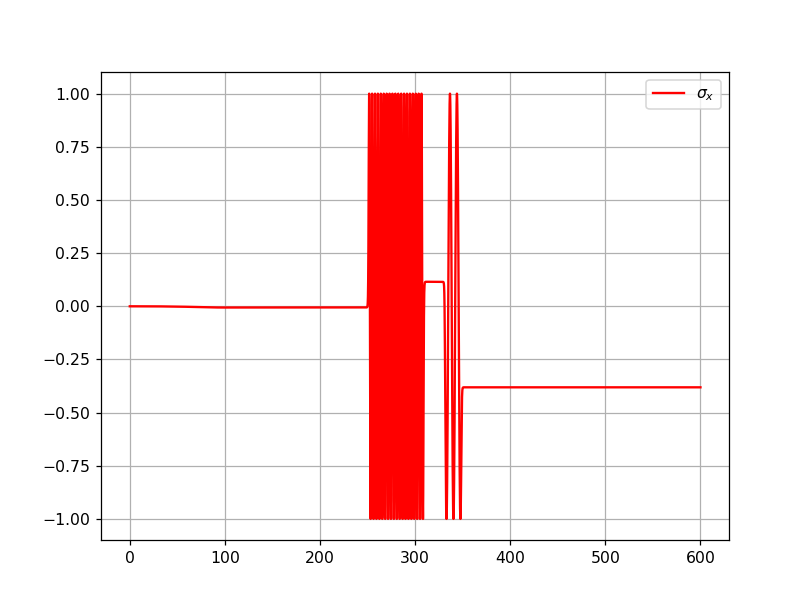

In [14]:
figure()
plot (Ts, x_interaction,'r', label = '$\sigma_x$')
#plot (Ts, y_interaction, 'g', label = '$\sigma_y$')
#plot (Ts, z_interaction, 'b', label = '$sigma_z$')
legend()
grid()

<IPython.core.display.Javascript object>


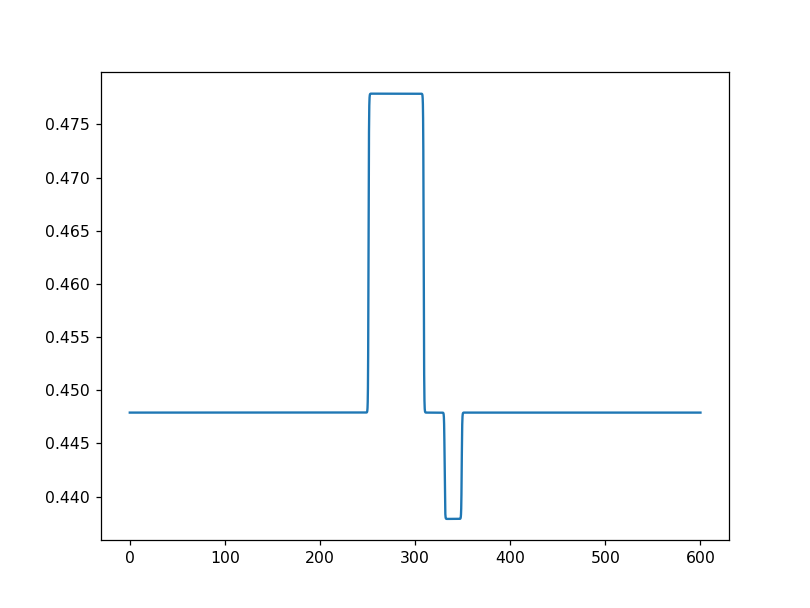

In [15]:
figure()
plot (Ts, waveform)

## $Oscillations\ between\ \mid 01\rangle\ and \mid10\rangle$

In [16]:
offset = 0.200
delta = 0.200
g = 0.01

s_up = basis(2,0)*basis(2,1).dag()

H = [[s_up*g, exp(1j*offset*Ts)]] + [[s_up.dag()*g, exp(-1j*offset*Ts)]] + [basis(2,1)*basis(2,1).dag()*delta]
rho0 = ket2dm(basis(2,0))
ops = [-ket2dm(basis(2, 0)) + ket2dm(basis(2, 1)),basis(2, 0) * basis(2, 1).dag() + basis(2, 1) * basis(2, 0).dag(),
      1j * basis(2, 0) * basis(2, 1).dag() - 1j * basis(2, 1) * basis(2, 0).dag()]
result = mesolve(H, rho0, Ts, c_ops = [],e_ops = ops,progress_bar=None,options=Options(nsteps = 20000, store_states = True))

<ipython-input-16-b1579388c5a5>:7: DeprecationWarning: scipy.exp is deprecated and will be removed in SciPy 2.0.0, use numpy.exp instead
  H = [[s_up*g, exp(1j*offset*Ts)]] + [[s_up.dag()*g, exp(-1j*offset*Ts)]] + [basis(2,1)*basis(2,1).dag()*delta]


<IPython.core.display.Javascript object>


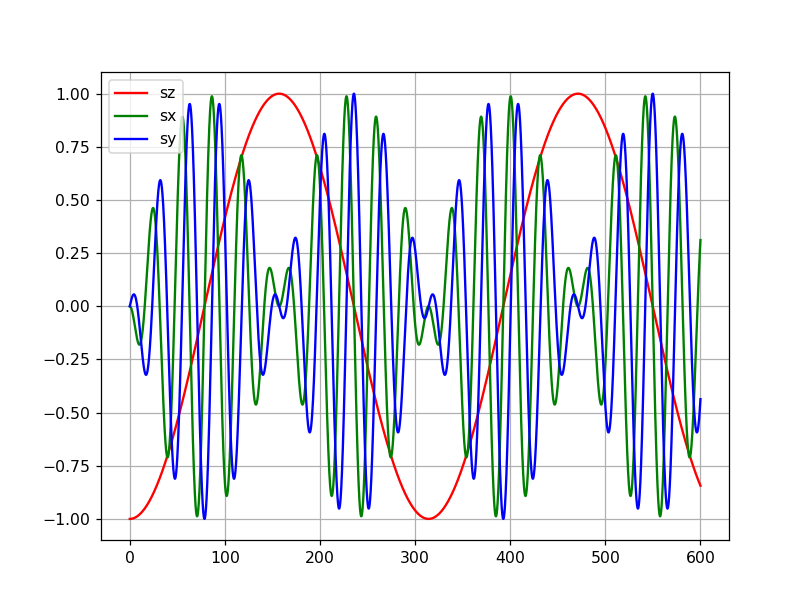

In [17]:
figure()
plot (Ts, result.expect[0],'r', label = 'sz')
plot (Ts, result.expect[1], 'g', label = 'sx')
plot (Ts, result.expect[2], 'b', label = 'sy')
legend()
grid()

## Qubit spectrum

In [18]:
phis = linspace (0, 1, 2000)
freqs_exact = []
freqs_approx = []
for phi in phis:
    H_3lvl_transmon = tr1.H_diag_trunc(phi)
    evals,evecs = H_3lvl_transmon.eigenstates()
    freqs_exact.append([(evals[1]-evals[0])/2/pi,(evals[2]-evals[0])/2/2/pi])
    H_3lvl_transmon_approx = tr1.H_diag_trunc_approx(phi)
    evals_approx,evecs_approx = H_3lvl_transmon_approx.eigenstates()
    freqs_approx.append([(evals_approx[1]-evals_approx[0])/2/pi,(evals_approx[2]-evals_approx[0])/2/2/pi])




<ipython-input-18-1f57efe26a87>:1: DeprecationWarning: scipy.linspace is deprecated and will be removed in SciPy 2.0.0, use numpy.linspace instead
  phis = linspace (0, 1, 2000)


In [19]:
freqs_exact_t = array(freqs_exact).T
freqs_approx_t = array(freqs_approx).T

<ipython-input-19-d25026310440>:1: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  freqs_exact_t = array(freqs_exact).T
<ipython-input-19-d25026310440>:2: DeprecationWarning: scipy.array is deprecated and will be removed in SciPy 2.0.0, use numpy.array instead
  freqs_approx_t = array(freqs_approx).T


<IPython.core.display.Javascript object>


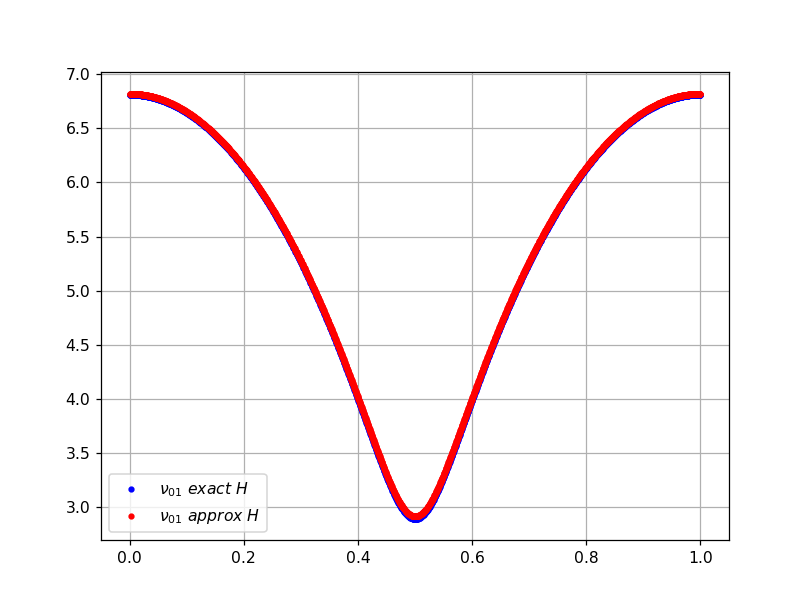

In [20]:
figure()
plot (phis,freqs_exact_t[0], 'b.',label ='$ \\nu_{01}\ exact\ H$')
plot (phis,freqs_approx_t[0],'r.', label = '$ \\nu_{01}\ approx\ H$')
legend()
grid()